In [43]:
import csv

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import label_binarize

tf.device('/gpu:0')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
RANDOM_SEED = 42

Num GPUs Available:  0


# Specify each path

In [44]:
dataset = '../model/keypoint_classifier/keypoint.csv'
model_save_path = '../model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = '../model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [45]:
NUM_CLASSES = 6

# Dataset reading

In [46]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [47]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Xử lý dữ liệu

## THỐNG KÊ VÀ TÌM HIỂU DỮ LIỆU

---

In [49]:
X_dataset_check = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(0, (21 * 2) + 1)))
X_dataset_check = pd.DataFrame(X_dataset_check)
print(X_dataset_check)

        0    1    2         3         4         5         6         7   \
0      0.0  0.0  0.0 -0.142105  0.026316 -0.294737 -0.005263 -0.315789   
1      0.0  0.0  0.0 -0.142857  0.021978 -0.302198 -0.027473 -0.313187   
2      0.0  0.0  0.0 -0.150838  0.016760 -0.307263 -0.039106 -0.318436   
3      0.0  0.0  0.0 -0.149425  0.022989 -0.316092 -0.022989 -0.321839   
4      0.0  0.0  0.0 -0.161677  0.005988 -0.329341 -0.053892 -0.323353   
...    ...  ...  ...       ...       ...       ...       ...       ...   
21939  5.0  0.0  0.0  0.315315 -0.090090  0.558559 -0.387387  0.594595   
21940  5.0  0.0  0.0  0.223464 -0.061453  0.363128 -0.262570  0.413408   
21941  5.0  0.0  0.0  0.165493 -0.059859  0.274648 -0.246479  0.204225   
21942  5.0  0.0  0.0 -0.030675 -0.104294 -0.012270 -0.276074  0.122699   
21943  5.0  0.0  0.0 -0.185714 -0.121429 -0.314286 -0.342857 -0.250000   

             8         9   ...        33        34        35        36  \
0     -0.142105 -0.289474  ... -0.168

In [50]:
X_dataset_check.head(15)

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.0,0.0,0.0,-0.142105,0.026316,-0.294737,-0.005263,-0.315789,-0.142105,-0.289474,...,-0.168421,-0.178947,-0.200000,-0.405263,-0.173684,-0.436842,-0.121053,-0.305263,-0.121053,-0.236842
1,0.0,0.0,0.0,-0.142857,0.021978,-0.302198,-0.027473,-0.313187,-0.170330,-0.269231,...,-0.159341,-0.197802,-0.175824,-0.434066,-0.148352,-0.461538,-0.104396,-0.318681,-0.104396,-0.247253
2,0.0,0.0,0.0,-0.150838,0.016760,-0.307263,-0.039106,-0.318436,-0.184358,-0.273743,...,-0.167598,-0.206704,-0.167598,-0.441341,-0.145251,-0.469274,-0.106145,-0.318436,-0.106145,-0.245810
3,0.0,0.0,0.0,-0.149425,0.022989,-0.316092,-0.022989,-0.321839,-0.172414,-0.270115,...,-0.172414,-0.201149,-0.166667,-0.471264,-0.109195,-0.454023,-0.080460,-0.304598,-0.103448,-0.241379
4,0.0,0.0,0.0,-0.161677,0.005988,-0.329341,-0.053892,-0.323353,-0.209581,-0.257485,...,-0.161677,-0.221557,-0.143713,-0.502994,-0.089820,-0.473054,-0.065868,-0.311377,-0.089820,-0.239521
5,0.0,0.0,0.0,-0.164634,0.006098,-0.335366,-0.067073,-0.329268,-0.219512,-0.262195,...,-0.170732,-0.237805,-0.140244,-0.518293,-0.079268,-0.487805,-0.067073,-0.323171,-0.091463,-0.262195
6,0.0,0.0,0.0,-0.136364,0.040404,-0.282828,0.020202,-0.323232,-0.116162,-0.318182,...,-0.186869,-0.161616,-0.232323,-0.358586,-0.207071,-0.393939,-0.151515,-0.272727,-0.151515,-0.207071
7,0.0,0.0,0.0,-0.172185,-0.006623,-0.350993,-0.099338,-0.337748,-0.258278,-0.245033,...,-0.152318,-0.251656,-0.092715,-0.523179,-0.039735,-0.483444,-0.033113,-0.311258,-0.072848,-0.245033
8,0.0,0.0,0.0,-0.188406,-0.028986,-0.376812,-0.144928,-0.326087,-0.318841,-0.210145,...,-0.144928,-0.289855,-0.050725,-0.594203,0.007246,-0.543478,-0.007246,-0.355072,-0.043478,-0.289855
9,0.0,0.0,0.0,-0.185185,0.051852,-0.385185,-0.037037,-0.355556,-0.222222,-0.229630,...,-0.155556,-0.214815,-0.044444,-0.525926,0.022222,-0.429630,0.007407,-0.244444,-0.044444,-0.192593


In [51]:
# In thông tin các cột trong DF => không tồn tại kiểu dự liệu phi số, không sữ liệu rỗng, dữ liệu đã được tiền xử lý
X_dataset_check.info()
print('Shape tập dữ liệu: ', X_dataset_check.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21944 entries, 0 to 21943
Data columns (total 43 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       21944 non-null  float32
 1   1       21944 non-null  float32
 2   2       21944 non-null  float32
 3   3       21944 non-null  float32
 4   4       21944 non-null  float32
 5   5       21944 non-null  float32
 6   6       21944 non-null  float32
 7   7       21944 non-null  float32
 8   8       21944 non-null  float32
 9   9       21944 non-null  float32
 10  10      21944 non-null  float32
 11  11      21944 non-null  float32
 12  12      21944 non-null  float32
 13  13      21944 non-null  float32
 14  14      21944 non-null  float32
 15  15      21944 non-null  float32
 16  16      21944 non-null  float32
 17  17      21944 non-null  float32
 18  18      21944 non-null  float32
 19  19      21944 non-null  float32
 20  20      21944 non-null  float32
 21  21      21944 non-null  float32
 22

## Check số lượng các nhãn
---

          Nhãn  Quy đổi
0      Nothing      0.0
1      Nothing      0.0
2      Nothing      0.0
3      Nothing      0.0
4      Nothing      0.0
...        ...      ...
21939    Click      5.0
21940    Click      5.0
21941    Click      5.0
21942    Click      5.0
21943    Click      5.0

[21944 rows x 2 columns]


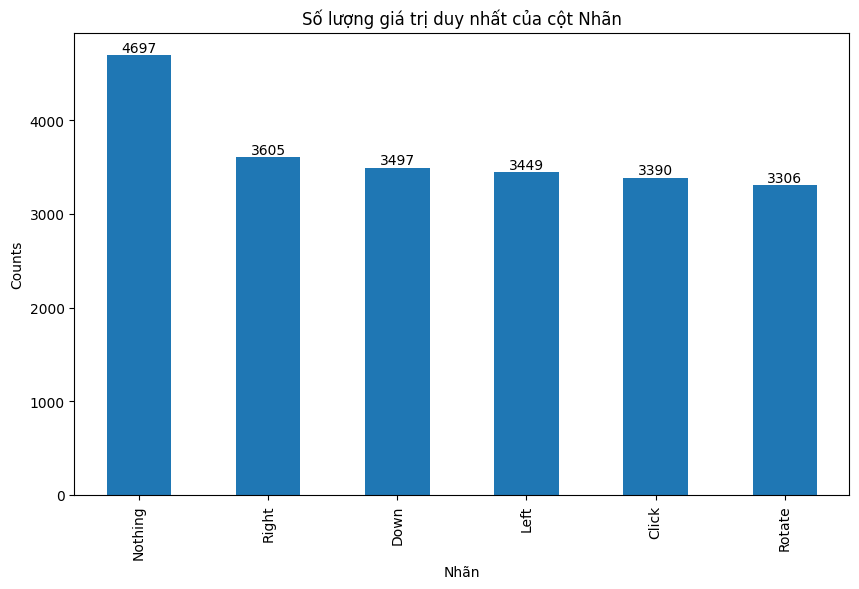

-----------------------------------------------
Số các giá trị duy nhất của cột Nhãn:
Nhãn
Nothing    4697
Right      3605
Down       3497
Left       3449
Click      3390
Rotate     3306
Name: count, dtype: int64


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

def categories_counts(label_name, dataset):
    print(f'-----------------------------------------------')
    print(f'Số các giá trị duy nhất của cột {label_name}:')
    print(dataset[label_name].value_counts())
    
def plt_categories_counts(label_name, dataset):
    counts = dataset[label_name].value_counts()
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar')
     # Hiển thị số liệu trên các cột
    for i, count in enumerate(counts):
        plt.annotate(str(count), xy=(i, count), ha='center', va='bottom')
    plt.title(f'Số lượng giá trị duy nhất của cột {label_name}')
    plt.xlabel(label_name)
    plt.ylabel('Counts')
    plt.show()
    categories_counts(label_name, dataset)

label = X_dataset_check[0]
label = pd.DataFrame(label)

a = len(label)
new_column = [None] * len(label)
new_column = pd.DataFrame(new_column)
label = pd.concat([new_column,label],axis=1)
label.columns = ['Nhãn', 'Quy đổi']

label.loc[label['Quy đổi'] == 0, 'Nhãn'] = 'Nothing'
label.loc[label['Quy đổi'] == 1, 'Nhãn'] = 'Left'
label.loc[label['Quy đổi'] == 2, 'Nhãn'] = 'Right'
label.loc[label['Quy đổi'] == 3, 'Nhãn'] = 'Rotate'
label.loc[label['Quy đổi'] == 4, 'Nhãn'] = 'Down'
label.loc[label['Quy đổi'] == 5, 'Nhãn'] = 'Click'

print(label)

# Đếm các giá trị duy nhất của các cột có Nhãn 
plt_categories_counts('Nhãn', label)


## Kiểm tra mức độ sạch của dữ liệu
---

In [53]:
def statistical_missing_data(dataFrame):
    # Kiểm tra số lượng giá trị khuyết cho mỗi cột
    missing_data = dataFrame.isnull().sum()
    
    # Tính tổng số lượng giá trị khuyết
    duplicate_data = dataFrame.duplicated().sum()

    # Tính tỷ lệ giá trị khuyết trên tổng số giá trị
    percent_missing = (duplicate_data / (dataFrame.shape[0] * dataFrame.shape[1])) * 100

    print("Số liệu thiếu trong mỗi cột:, ")
    print(missing_data)
    print("\nSố liệu trùng lặp: ", duplicate_data)
    print("Tỷ lệ giá trị khuyết trên tổng số giá trị (%): {:.2f}".format(percent_missing))

# Thống kê dữ liệu khuyết
statistical_missing_data(X_dataset_check)

Số liệu thiếu trong mỗi cột:, 
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
dtype: int64

Số liệu trùng lặp:  1
Tỷ lệ giá trị khuyết trên tổng số giá trị (%): 0.00


In [54]:
def plt_statistics_missing_data(dataFrame):
    # Dữ liệu khuyết
    missing_data = dataFrame.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    plt.figure(figsize=(10, 5))
    missing_data.plot(kind='bar')
    plt.title('Dữ liệu khuyết trong mỗi cột')
    plt.xlabel('Tên cột')
    plt.ylabel('Số lượng dữ liệu khuyết')
    plt.show()

    # Dữ liệu lặp
    duplicate_data = dataFrame.duplicated().sum()
    print("\nSố liệu trùng lặp:", duplicate_data)

# Thống kê dữ liệu khuyết
# plt_statistics_missing_data(X_dataset_check)
missing_data = X_dataset_check.isnull().sum()
print(missing_data.to_frame().T)
# missing_data.to_frame().T.to_csv('../test.txt', sep='\t', index=False)


   0   1   2   3   4   5   6   7   8   9   ...  33  34  35  36  37  38  39  \
0   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

   40  41  42  
0   0   0   0  

[1 rows x 43 columns]


In [55]:
X_dataset_check.describe()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
count,21944.000000,21944.0,21944.0,21944.000000,21944.000000,21944.000000,21944.000000,21944.000000,21944.000000,21944.000000,...,21944.000000,21944.000000,21944.000000,21944.000000,21944.000000,21944.000000,21944.000000,21944.000000,21944.000000,21944.000000
mean,2.347567,0.0,0.0,-0.004944,-0.105018,-0.006711,-0.280901,-0.007232,-0.437089,-0.010870,...,-0.015703,-0.475057,-0.005503,-0.469603,-0.007871,-0.580970,-0.006834,-0.574269,-0.007187,-0.599171
std,1.752516,0.0,0.0,0.228201,0.121246,0.406223,0.229840,0.492101,0.312813,0.513195,...,0.260114,0.321278,0.270116,0.238427,0.322663,0.305728,0.322992,0.321733,0.330226,0.363964
min,0.000000,0.0,0.0,-0.544304,-0.561404,-0.873563,-0.938596,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-0.931507,-1.000000,-1.000000,-1.000000,-0.992908,-1.000000,-1.000000,-1.000000
25%,1.000000,0.0,0.0,-0.190955,-0.174053,-0.318182,-0.391643,-0.367170,-0.581560,-0.357143,...,-0.161922,-0.627907,-0.187245,-0.581921,-0.199476,-0.752747,-0.194444,-0.807188,-0.187553,-0.909469
50%,2.000000,0.0,0.0,-0.060606,-0.120773,-0.073004,-0.322727,-0.045852,-0.491317,-0.007505,...,-0.018349,-0.441667,-0.025210,-0.495146,-0.022727,-0.664395,-0.023769,-0.666667,-0.028169,-0.634361
75%,4.000000,0.0,0.0,0.185043,-0.057570,0.300000,-0.234043,0.346342,-0.397705,0.326315,...,0.114067,-0.312757,0.168731,-0.396761,0.178269,-0.488753,0.168182,-0.418210,0.163265,-0.380496
max,5.000000,0.0,0.0,0.666667,0.472727,1.000000,0.828829,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.839506,1.000000,0.994253,1.000000,1.000000,1.000000,1.000000


In [56]:
# find the correlation among the columns in the Dataframe
X_dataset_check.corr()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,1.000000,NaN,NaN,-0.017572,0.032269,-0.002158,-0.035418,0.006094,-0.085989,0.012349,...,-0.001150,-0.070767,0.021619,-0.243570,0.020642,-0.280821,0.010513,-0.301182,0.007664,-0.306070
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.017572,NaN,NaN,1.000000,0.013857,0.983086,-0.016738,0.947819,-0.030128,0.881553,...,0.248722,-0.039194,-0.387877,-0.070631,-0.178784,-0.074472,-0.156241,-0.049874,-0.177382,-0.045154
4,0.032269,NaN,NaN,0.013857,1.000000,0.008601,0.938633,-0.003253,0.839971,-0.018468,...,0.004218,0.381240,0.013174,0.084520,0.023720,0.175866,0.019319,0.215675,0.015031,0.192741
5,-0.002158,NaN,NaN,0.983086,0.008601,1.000000,-0.022037,0.984430,-0.035575,0.927146,...,0.340680,-0.048320,-0.265195,-0.068718,-0.063958,-0.073827,-0.048701,-0.049363,-0.070456,-0.043016
6,-0.035418,NaN,NaN,-0.016738,0.938633,-0.022037,1.000000,-0.026926,0.969868,-0.032188,...,0.016380,0.468305,0.045182,0.328600,0.043628,0.408191,0.038304,0.383215,0.037016,0.326181
7,0.006094,NaN,NaN,0.947819,-0.003253,0.984430,-0.026926,1.000000,-0.035407,0.974929,...,0.392316,-0.049575,-0.178991,-0.061685,0.023888,-0.071912,0.036080,-0.052704,0.013631,-0.046589
8,-0.085989,NaN,NaN,-0.030128,0.839971,-0.035575,0.969868,-0.035407,1.000000,-0.033136,...,0.022628,0.488970,0.058222,0.462381,0.053835,0.536373,0.046781,0.475509,0.044983,0.398873
9,0.012349,NaN,NaN,0.881553,-0.018468,0.927146,-0.032188,0.974929,-0.033136,1.000000,...,0.400542,-0.045566,-0.120089,-0.054411,0.078560,-0.066820,0.089542,-0.051494,0.067771,-0.045802


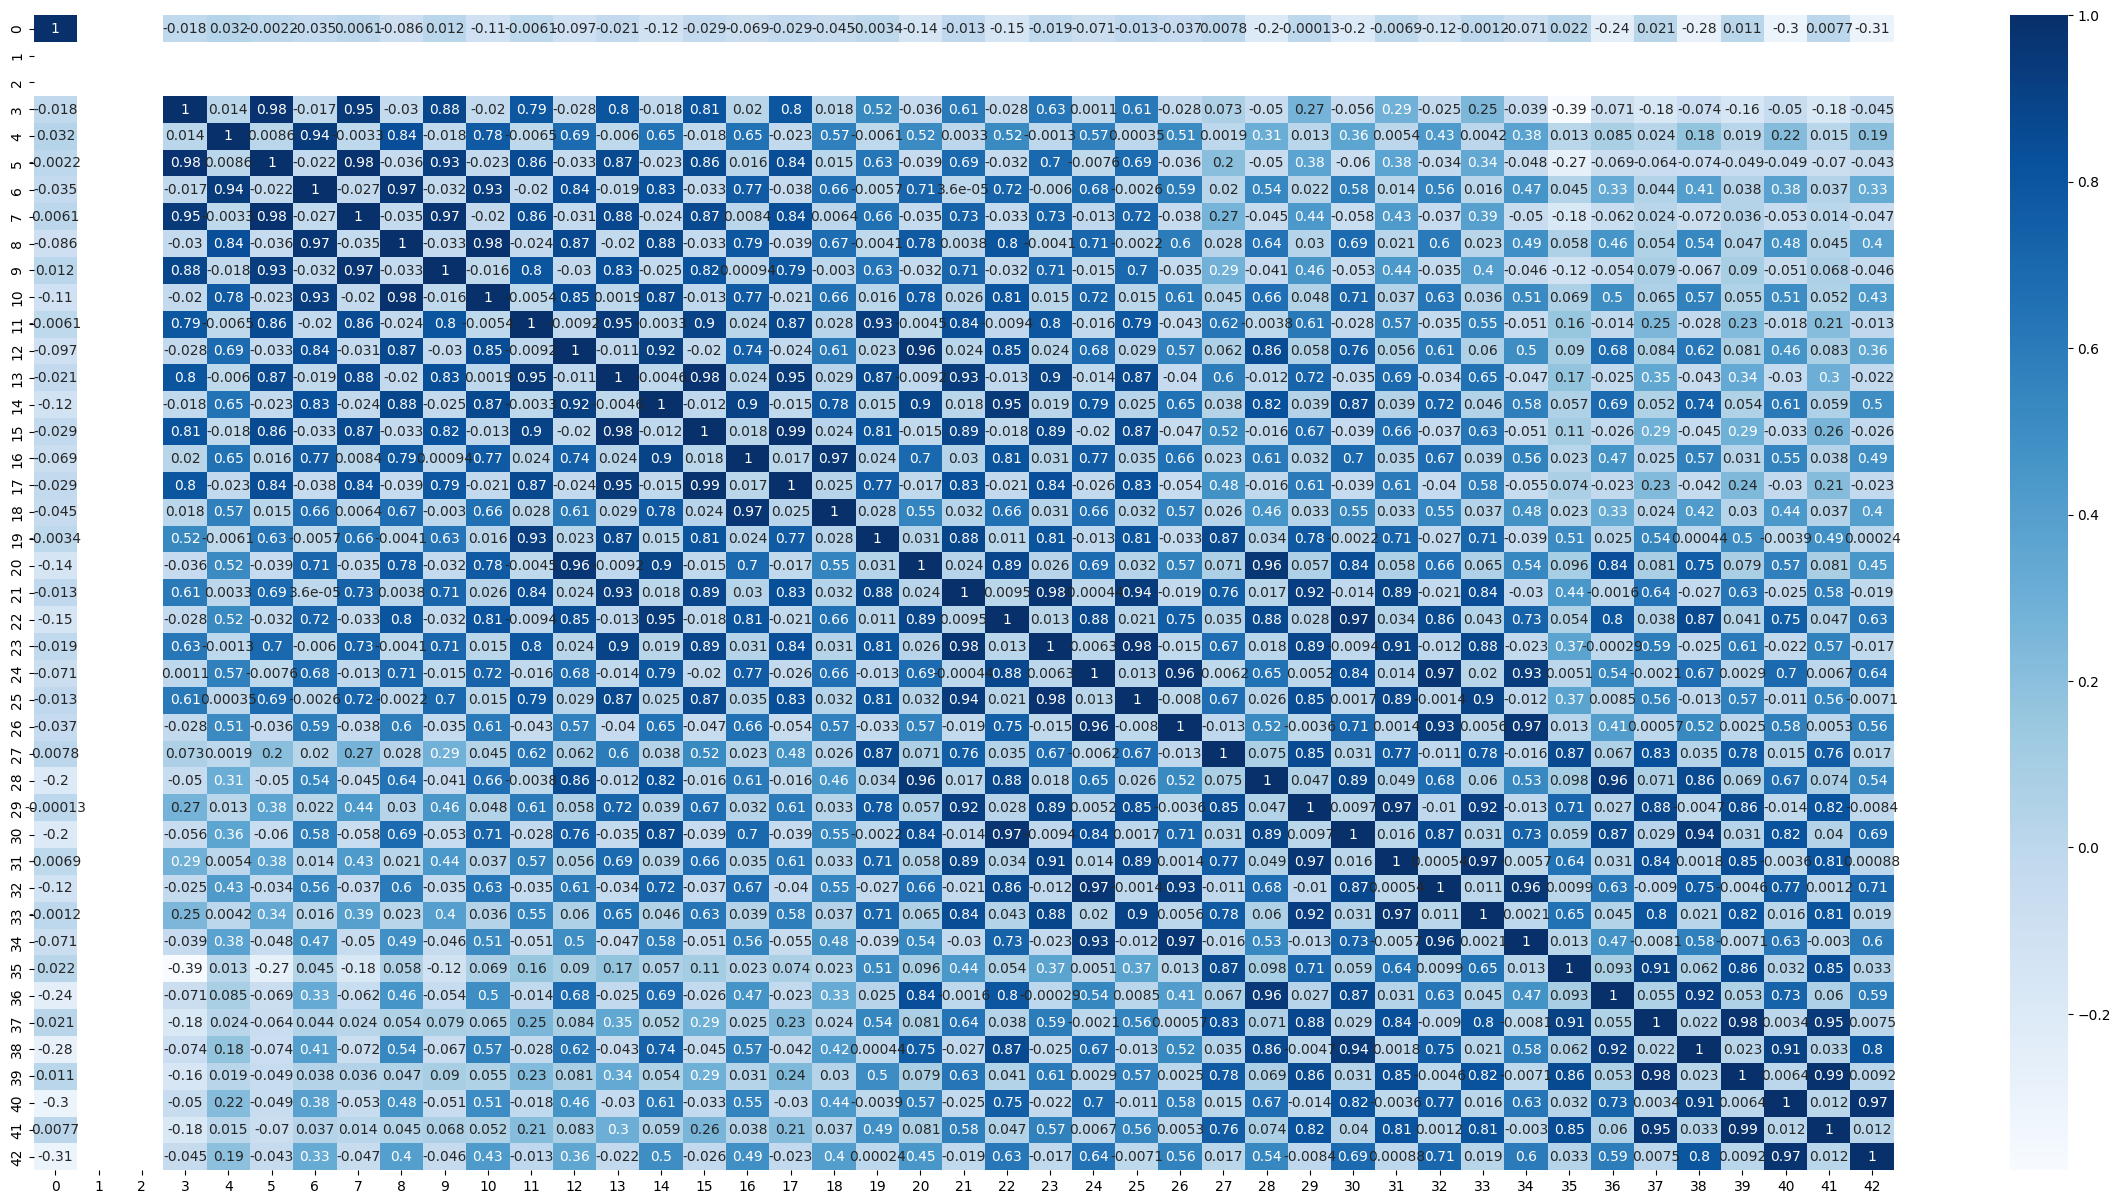

In [57]:
plt.figure(figsize = (30,15))
sns.heatmap(X_dataset_check.corr(numeric_only = True), annot = True, cmap = plt.cm.Blues)
plt.show()

# Model building

In [58]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),   
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [59]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 42)                0         
                                                                 
 dense_12 (Dense)            (None, 20)                860       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dense_14 (Dense)            (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False) # automatically save your model
# verbose : gọi lại thông báo mỗi khi thông báo
# save_weights_only: lưu lại cả mô hình lẫn thông số mô hình nếu False

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)
# dừng quá trình đào tạo nếu hiệu suất mô hình ko đc cải thiện

In [61]:
# Model compilation
model.compile(
    optimizer='adam', # hàm tối ưu
    loss='sparse_categorical_crossentropy', # hàm mất mát
    metrics=['accuracy'] # thuước  đo đánh giá
)

# Model training

In [62]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
126/129 [============================>.] - ETA: 0s - loss: 1.7717 - accuracy: 0.2075
Epoch 1: saving model to ../model/keypoint_classifier\keypoint_classifier.hdf5
129/129 [==============================] - 1s 7ms/step - loss: 1.7699 - accuracy: 0.2090 - val_loss: 1.6526 - val_accuracy: 0.3742
Epoch 2/1000
117/129 [==========================>...] - ETA: 0s - loss: 1.6719 - accuracy: 0.2848
Epoch 2: saving model to ../model/keypoint_classifier\keypoint_classifier.hdf5
129/129 [==============================] - 1s 4ms/step - loss: 1.6670 - accuracy: 0.2886 - val_loss: 1.4982 - val_accuracy: 0.4785
Epoch 3/1000
119/129 [==========================>...] - ETA: 0s - loss: 1.5749 - accuracy: 0.3590
Epoch 3: saving model to ../model/keypoint_classifier\keypoint_classifier.hdf5
129/129 [==============================] - 1s 5ms/step - loss: 1.5707 - accuracy: 0.3617 - val_loss: 1.3307 - val_accuracy: 0.5664
Epoch 4/1000
105/129 [=======================>......] - ETA: 0s - loss: 1.47

In [63]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

43/43 [==============================] - 0s 1ms/step - loss: 0.7394 - accuracy: 0.7603


In [64]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [65]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 78ms/step
[0.02263031 0.6187194  0.11510664 0.00934925 0.22544155 0.00875293]
1


# Draw Loss and Accuracy

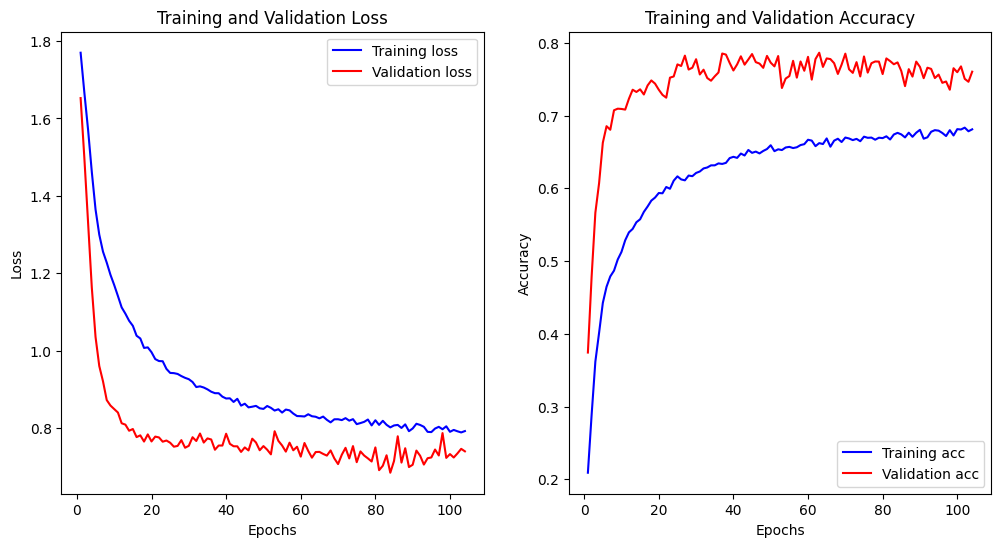

In [66]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Lấy thông tin về loss và accuracy từ history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Vẽ biểu đồ Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Vẽ biểu đồ Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

172/172 [==============================] - 0s 2ms/step
Accuracy: 0.7602989427633977
Precision: 0.7727453148416016
Recall: 0.7639606301960712
ROC AUC: 0.9575854405352282
F1-score for class 0 : 0.748755092802173
F1-score for class 1 : 0.629404617253949
F1-score for class 2 : 0.7600411946446962
F1-score for class 3 : 0.8423855165069223
F1-score for class 4 : 0.761596548004315
F1-score for class 5 : 0.8191268191268191
Average F1-score: 0.7587604898767596
ROC AUC: {0: 0.9430636466467727, 1: 0.9435632677570854, 2: 0.9522082243559024, 3: 0.9797749454563485, 4: 0.9650016508241075, 5: 0.9619009081711527}


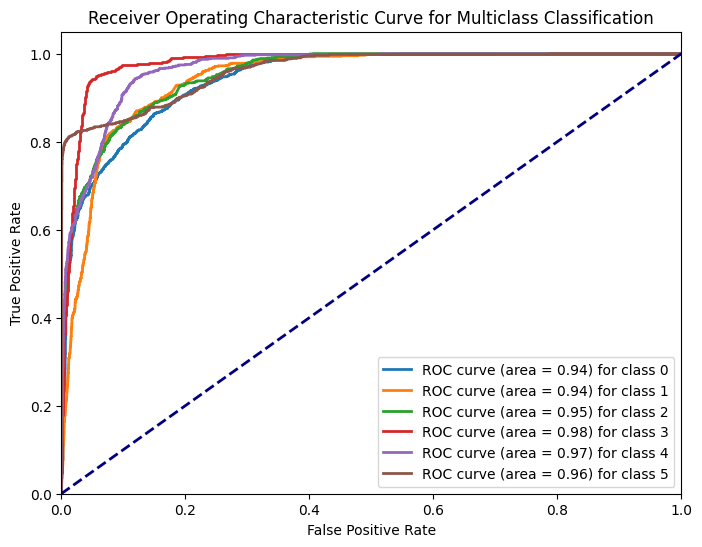

In [67]:
# Định nghĩa hàm plot_roc_curve để vẽ đường cong ROC
def plot_roc_curve(fpr, tpr):
    # Vẽ đường cong ROC cho từng lớp
    plt.figure(figsize=(8, 6))
    for i in range(NUM_CLASSES):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve for Multiclass Classification')
    plt.legend(loc="lower right")
    plt.show()

# Dự đoán xác suất cho từng lớp
y_pred_prob = model.predict(X_test)
# Chọn ra lớp có xác suất cao nhất
y_pred = np.argmax(y_pred_prob, axis=1)

# Tính toán các metric
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# In kết quả
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC:", roc_auc)

# Tính toán F1-score cho mỗi lớp
f1_scores = f1_score(y_test, y_pred, average=None)

# In ra F1-score của từng lớp
for i in range(NUM_CLASSES):
    print("F1-score for class", i, ":", f1_scores[i])

# Tính toán F1-score trung bình trên tất cả các lớp
average_f1_score = f1_score(y_test, y_pred, average='weighted')
print("Average F1-score:", average_f1_score)

def draw_roc_corve():
    
    # Chuyển đổi nhãn về dạng one-hot encoding
    y_test_one_hot = label_binarize(y_test, classes=np.arange(NUM_CLASSES))

    # Tính toán đường cong ROC cho mỗi lớp
    fpr = dict()
    tpr = dict()
    global roc_auc
    roc_auc = dict()
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    print("ROC AUC:", roc_auc)
    # Vẽ đường cong ROC
    plot_roc_curve(fpr, tpr)
draw_roc_corve()

# Confusion matrix

172/172 [==============================] - 0s 857us/step


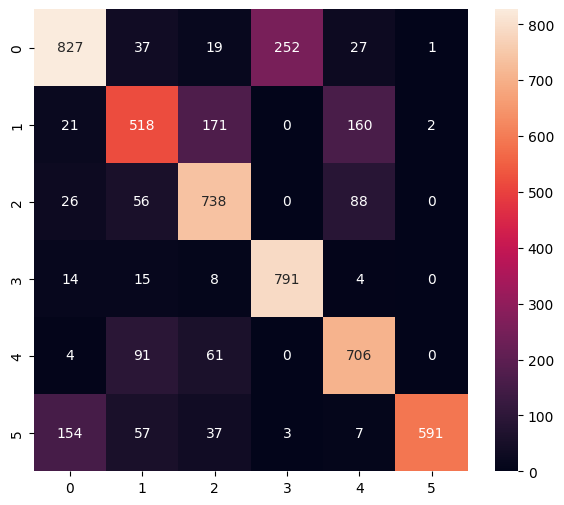

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.71      0.75      1163
           1       0.67      0.59      0.63       872
           2       0.71      0.81      0.76       908
           3       0.76      0.95      0.84       832
           4       0.71      0.82      0.76       862
           5       0.99      0.70      0.82       849

    accuracy                           0.76      5486
   macro avg       0.77      0.76      0.76      5486
weighted avg       0.77      0.76      0.76      5486



In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [69]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [70]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmp3mnbmbif\assets


6696

# Inference test

In [71]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [72]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_5:0', 'index': 0, 'shape': array([ 1, 42]), 'shape_signature': array([-1, 42]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [73]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [74]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 31.2 ms
Wall time: 22.1 ms


In [75]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.02263029 0.61871946 0.11510661 0.00934924 0.22544147 0.00875293]
1
